In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier




In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")

In [3]:
# df = preprocess_data(df)

In [4]:
# Extract time-based features
df = df.withColumn("Hour", F.hour("Start_Time"))
df = df.withColumn("DayOfWeek", F.dayofweek("Start_Time"))  # Sunday = 1
df = df.withColumn("Month", F.month("Start_Time"))

# Calculate duration in minutes
df = df.withColumn("Duration", (F.unix_timestamp("End_Time") - F.unix_timestamp("Start_Time")) / 60)

# Add Is_Weekend column: Saturday (7) or Sunday (1)
df = df.withColumn("Is_Weekend", F.when(F.col("DayOfWeek").isin(1, 7), 1).otherwise(0))

In [5]:
# Define features and target variable
features = [
    "Start_Lat", "Start_Lng", "Temperature(F)", "Humidity(%)", 
    "Visibility(mi)", "Precipitation(in)", "Hour", "DayOfWeek", 
    "Month", "Junction", "Crossing", "Traffic_Signal"
]
target = "Risk_Score"  # Continuous target for regression

In [6]:
# Aggregate data by State
state_risk = df.groupBy("State").agg(
    F.avg("Severity").alias("Avg_Severity"),
    F.count("*").alias("Accident_Count")
).withColumn(
    "Risk_Score", F.col("Avg_Severity") * F.col("Accident_Count")
)

# Show top 10 states with highest risk scores
state_risk.orderBy(F.col("Risk_Score").desc()).show(10)

+-----+------------------+--------------+-----------------+
|State|      Avg_Severity|Accident_Count|       Risk_Score|
+-----+------------------+--------------+-----------------+
|   CA|2.1656876836490406|       1741433|        3771400.0|
|   FL|2.1400603504689886|        880192|        1883664.0|
|   TX|2.2241244121426744|        582837|        1296302.0|
|   SC|2.1110553460007266|        382557|         807599.0|
|   NY| 2.259549948269916|        347960|         786233.0|
|   NC| 2.133823577242984|        338199|         721657.0|
|   VA|2.2789736928002218|        303301|691215.0000000001|
|   PA| 2.205764951790169|        296620|         654274.0|
|   GA|2.5069312313128567|        169234|         424258.0|
|   MN|  2.16201765894088|        192084|         415289.0|
+-----+------------------+--------------+-----------------+
only showing top 10 rows



In [7]:
# Example: Add average visibility and precipitation by state
state_features = df.groupBy("State").agg(
    F.avg("Visibility(mi)").alias("Avg_Visibility"),
    F.avg("Precipitation(in)").alias("Avg_Precipitation")
)

# Join features with risk scores
state_risk = state_risk.join(state_features, on="State", how="inner")

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

features = ["Accident_Count", "Avg_Severity", "Avg_Visibility", "Avg_Precipitation"]

assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
state_risk = assembler.transform(state_risk)

scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(state_risk)
state_risk = scaler_model.transform(state_risk)

train_df, test_df = state_risk.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features_scaled", labelCol="Risk_Score", seed=42)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="Risk_Score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 278165.40421380044


In [9]:
# Evaluate using Mean Absolute Error (MAE)
evaluator = RegressionEvaluator(labelCol="Risk_Score", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using R-Squared (R²)
evaluator = RegressionEvaluator(labelCol="Risk_Score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")



Mean Absolute Error (MAE): 181116.4487549067
R-Squared (R²): 0.7041498904151144


In [10]:
df = df.join(state_risk.select("State", "Risk_Score"), on="State", how="left").cache()
quantile_75 = df.approxQuantile("Risk_Score", [0.75], 0)[0]
df = df.withColumn("Is_High_Risk", F.when(F.col("Risk_Score") > quantile_75, 1).otherwise(0))

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features_scaled", labelCol="Is_High_Risk", seed=42)
rf_classifier_model = rf_classifier.fit(train_df)

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
# Make predictions
predictions = rf_classifier_model.transform(test_df)

# Evaluate model performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Binary Classification Evaluator (AUC)
evaluator = BinaryClassificationEvaluator(labelCol="Is_High_Risk", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

# Accuracy
acc_eval = MulticlassClassificationEvaluator(labelCol="Is_High_Risk", predictionCol="prediction", metricName="accuracy")
accuracy = acc_eval.evaluate(predictions)

# Precision
prec_eval = MulticlassClassificationEvaluator(labelCol="Is_High_Risk", predictionCol="prediction", metricName="weightedPrecision")
precision = prec_eval.evaluate(predictions)

# Recall
recall_eval = MulticlassClassificationEvaluator(labelCol="Is_High_Risk", predictionCol="prediction", metricName="weightedRecall")
recall = recall_eval.evaluate(predictions)

# F1 Score
f1_eval = MulticlassClassificationEvaluator(labelCol="Is_High_Risk", predictionCol="prediction", metricName="f1")
f1 = f1_eval.evaluate(predictions)

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

C:\Users\Ahmed Osama\AppData\Local\Temp\ipykernel_34000\22975415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_risk_pd, x="State", y="Risk_Score", palette="viridis")


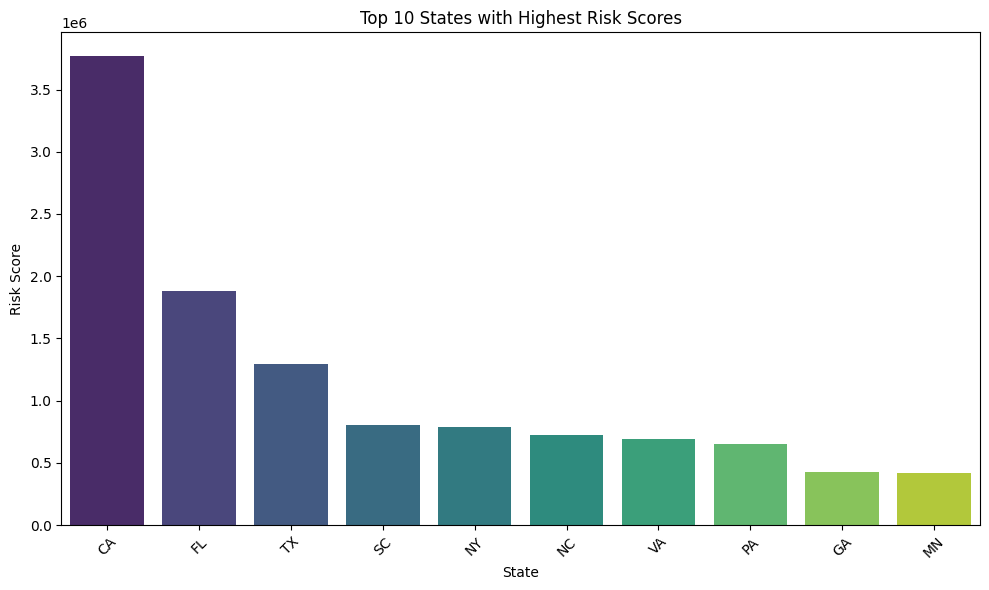

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for visualization
state_risk_pd = state_risk.orderBy(F.col("Risk_Score").desc()).limit(10).toPandas()

# Bar plot of top 10 states
plt.figure(figsize=(10, 6))
sns.barplot(data=state_risk_pd, x="State", y="Risk_Score", palette="viridis")
plt.title("Top 10 States with Highest Risk Scores")
plt.xlabel("State")
plt.ylabel("Risk Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()